# Purpose
Predict car or truck from image

In [1]:
import os

import numpy as np
import math

import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image
import wandb
from wandb.keras import WandbCallback

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2

In [2]:
files=[]
walkpath = '../car_or_truck/corrected_data/'
# walkpath = '../car_or_truck/raw_data/'

for dirname, _, filenames in os.walk(walkpath):
    for filename in filenames:
        filepath = Path(dirname).joinpath(filename)
        files.append((filepath, filepath.parent.name))

In [66]:
files

[(WindowsPath('../car_or_truck/corrected_data/train/Car/00002.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00004.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00011.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00016.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00017.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00019.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00020.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00023.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00025.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00035.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00037.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00038.jpeg'), 'Car'),
 (WindowsPath('../car_or_truck/corrected_data/train/Car/00039.jp

In [3]:
array = np.asarray(files)
labels = np.unique(array[:, 1], return_counts=True)
dict(zip(*labels))

{'Car': 4408, 'Truck': 3265}

In [68]:
array

array([[WindowsPath('../car_or_truck/corrected_data/train/Car/00002.jpeg'),
        'Car'],
       [WindowsPath('../car_or_truck/corrected_data/train/Car/00004.jpeg'),
        'Car'],
       [WindowsPath('../car_or_truck/corrected_data/train/Car/00011.jpeg'),
        'Car'],
       ...,
       [WindowsPath('../car_or_truck/corrected_data/valid/Truck/10163.jpeg'),
        'Truck'],
       [WindowsPath('../car_or_truck/corrected_data/valid/Truck/10166.jpeg'),
        'Truck'],
       [WindowsPath('../car_or_truck/corrected_data/valid/Truck/10167.jpeg'),
        'Truck']], dtype=object)

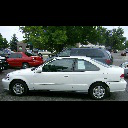

In [6]:
filepath, filelabel = array[0]
image = Image.open(filepath)
image

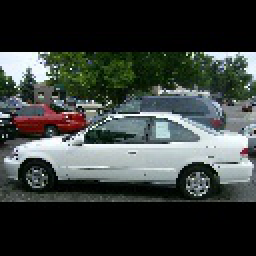

In [7]:
size = (256, 256)
image = image.resize(size, resample=0)
image

In [8]:
image = np.array(image)
image

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

# Image and label arrays

In [4]:
img_array = []
label_array = []
for path, label in array:
    image = Image.open(path)
    image = np.asarray(image)

    img_array.append(image)
    label_array.append(label)

img_array, label_array = np.asarray(img_array), np.asarray(label_array)
img_array.shape, label_array.shape

((7673, 128, 128, 3), (7673,))

# Encoder

In [5]:
encoder = LabelEncoder()
classes = encoder.fit_transform(label_array).reshape(-1, 1)
classes

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

# Data splits

In [6]:
x_train, x_test, y_train, y_test = train_test_split(img_array, classes, train_size=0.8, stratify=classes)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5, stratify=y_test)

# Data input generator

In [7]:
class CarOrTruckGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size):
        self.x, self.y = x, y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x, batch_y

    def on_epoch_end(self):
        indices = np.random.permutation(len(self.x))
        self.x, self.y = self.x[indices], self.y[indices]

In [8]:
train_gen = CarOrTruckGenerator(x_train, y_train, 128)
test_gen = CarOrTruckGenerator(x_test, y_test, 128)

# Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2)])

# Wandb

In [10]:
wandb.init(project="car_or_truck")

wandb: Currently logged in as: porpoising (use `wandb login --relogin` to force relogin)


# Setup

In [11]:
checkpoint_filepath = '../car_or_truck/artifacts/w-{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f'{filepath}logs/')

In [12]:
model_1 = tf.keras.Sequential([
    layers.Input(shape=x_train[0].shape),
    data_augmentation,

    layers.Conv2D(filters=32, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Conv2D(filters=48, kernel_size=5, strides=2, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Conv2D(filters=80, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    # layers.Dropout(0.3),
    #
    # layers.Conv2D(filters=96, kernel_size=3, strides=2, padding='same'),
    # layers.BatchNormalization(),
    # layers.Activation('relu'),
    # # layers.Dropout(0.35),

    layers.Flatten(),
    # layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 48)        38448     
                                                      

In [13]:
model_1.fit(x=train_gen,
            validation_data=(x_val, y_val), epochs=300,
            callbacks=[model_checkpoint_callback, WandbCallback()])

Epoch 1/300
48/48 [==============================] - 21s 208ms/step - loss: 1.0641 - accuracy: 0.5489 - val_loss: 0.6897 - val_accuracy: 0.5990 - _timestamp: 1648188996.0000 - _runtime: 467.0000
Epoch 2/300
48/48 [==============================] - 8s 171ms/step - loss: 0.7420 - accuracy: 0.5802 - val_loss: 0.6517 - val_accuracy: 0.6198 - _timestamp: 1648189004.0000 - _runtime: 475.0000
Epoch 3/300
48/48 [==============================] - 8s 170ms/step - loss: 0.7060 - accuracy: 0.6061 - val_loss: 0.7490 - val_accuracy: 0.5820 - _timestamp: 1648189013.0000 - _runtime: 484.0000
Epoch 4/300
48/48 [==============================] - 8s 176ms/step - loss: 0.7144 - accuracy: 0.5982 - val_loss: 0.6366 - val_accuracy: 0.6172 - _timestamp: 1648189021.0000 - _runtime: 492.0000
Epoch 5/300
48/48 [==============================] - 8s 175ms/step - loss: 0.7163 - accuracy: 0.6111 - val_loss: 0.6099 - val_accuracy: 0.6549 - _timestamp: 1648189030.0000 - _runtime: 501.0000
Epoch 6/300
48/48 [==========

In [16]:
model_1.load_weights('../car_or_truck/artifacts/w-239-0.38.h5')

In [17]:
from sklearn.metrics import accuracy_score

y_pred = model_1.predict(x_test)
score = accuracy_score(y_test, np.round(y_pred, 0))
print(f"Accuracy: {score:.2f}")

Accuracy: 0.85


# Failed predictions

In [89]:
indices = list(np.argwhere(np.round(y_pred, 0).astype(np.int32) != y_test.astype(np.int32))[:, 0])
failed_sample = x_test[indices]
failed_preds = y_pred[indices]
gt_preds = y_test[indices]

In [90]:
len(failed_sample), len(failed_preds), len(gt_preds)

(80, 80, 80)

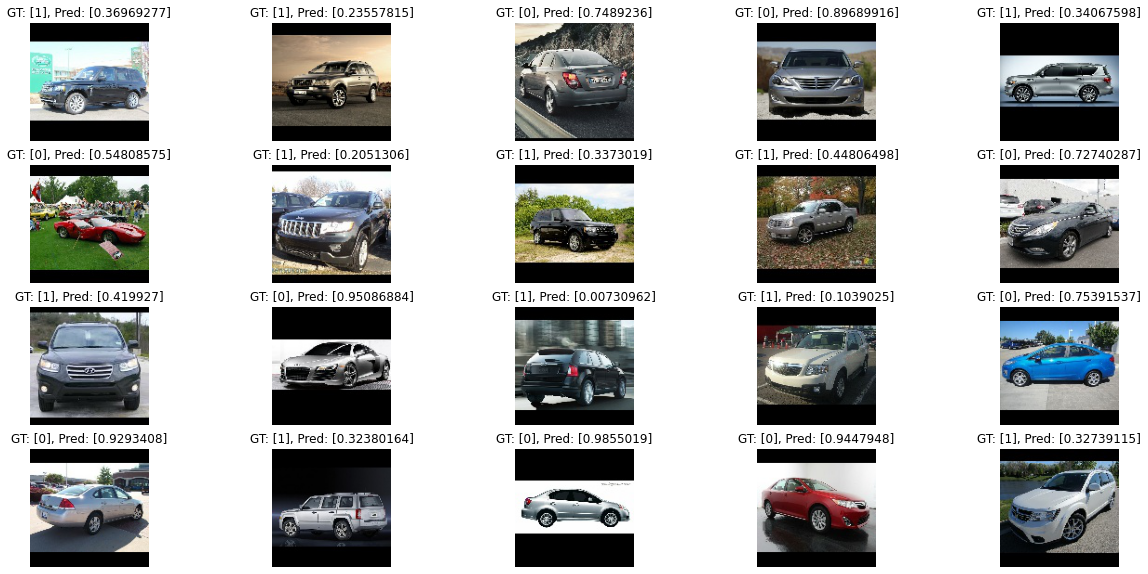

In [91]:
nrows, ncols = 4, 5
fig, axs = plt.subplots(nrows, ncols, figsize=(21, 10))
n = 0

for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(failed_sample[n])
        axs[i, j].set_title(f"GT: {gt_preds[n]}, Pred: {failed_preds[n]}")
        axs[i, j].axis('off')
        n += 1

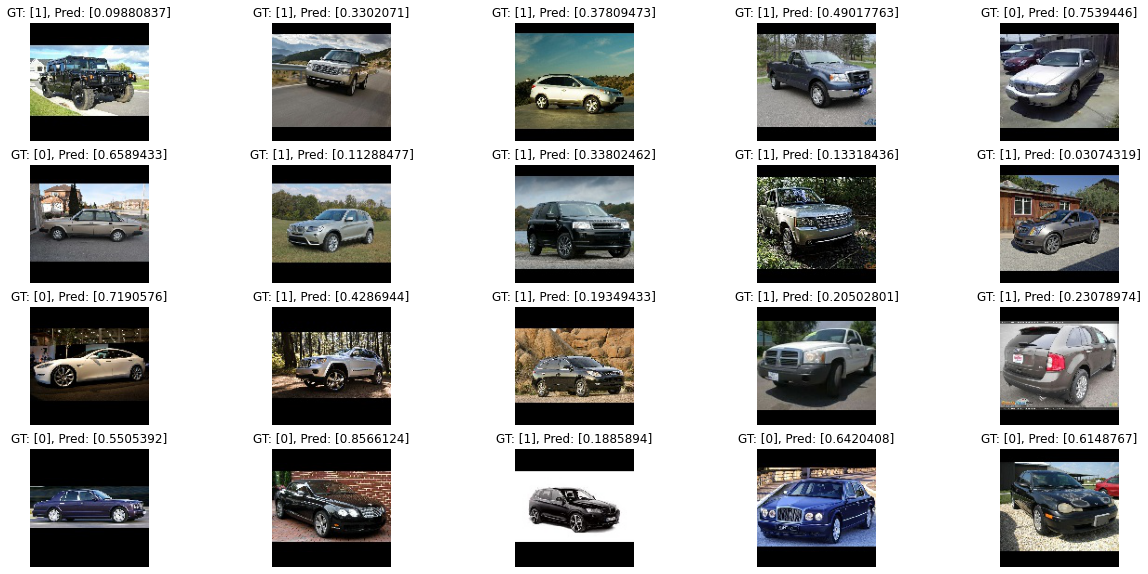

In [92]:
fig, axs = plt.subplots(nrows, ncols, figsize=(21, 10))

for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(failed_sample[n])
        axs[i, j].set_title(f"GT: {gt_preds[n]}, Pred: {failed_preds[n]}")
        axs[i, j].axis('off')
        n += 1

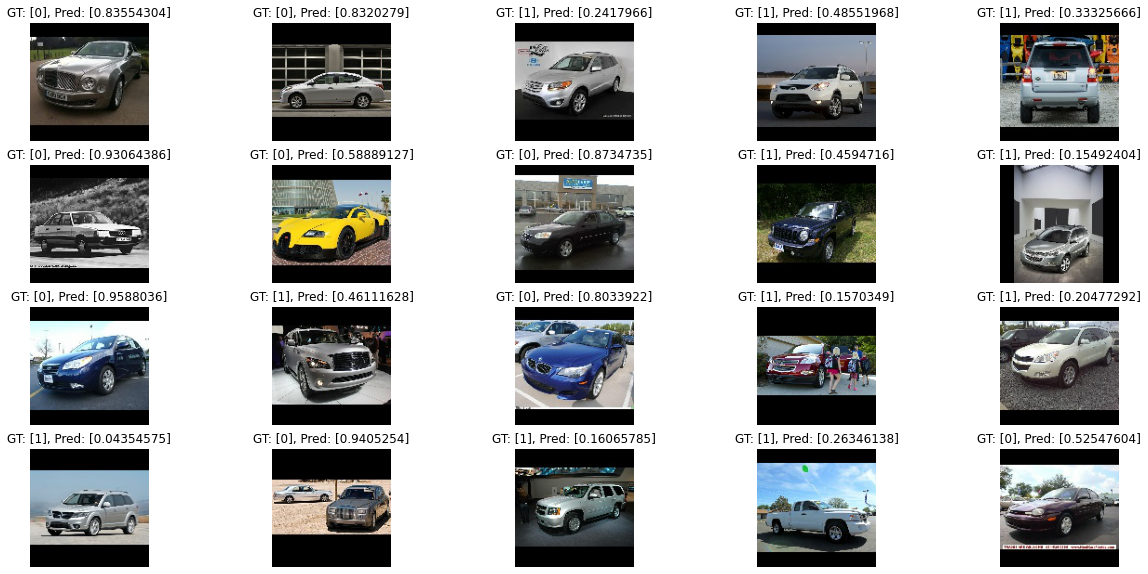

In [93]:
fig, axs = plt.subplots(nrows, ncols, figsize=(21, 10))

for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(failed_sample[n])
        axs[i, j].set_title(f"GT: {gt_preds[n]}, Pred: {failed_preds[n]}")
        axs[i, j].axis('off')
        n += 1

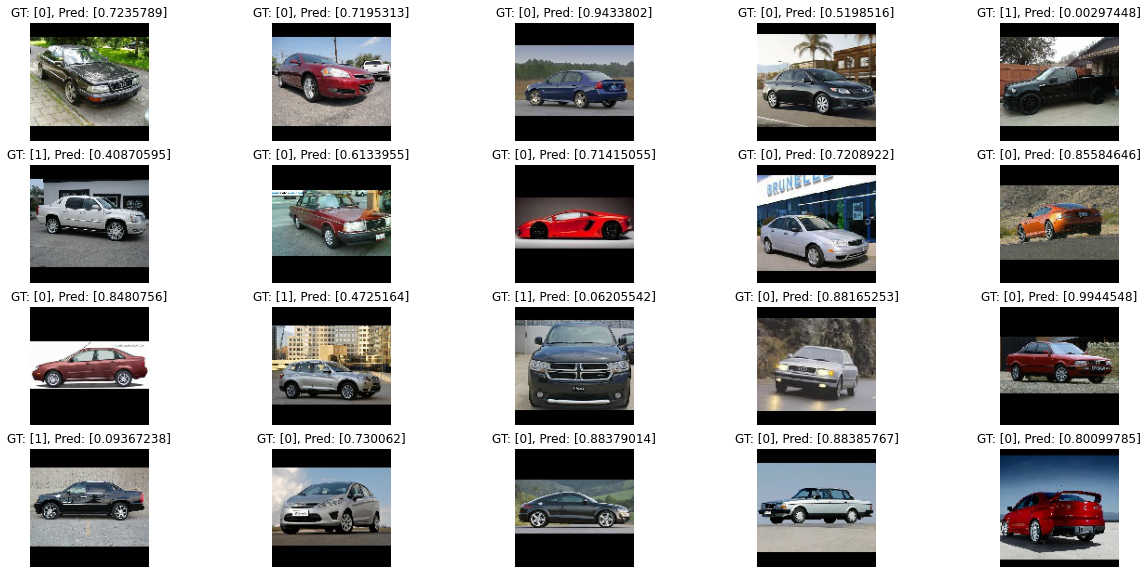

In [94]:
fig, axs = plt.subplots(nrows, ncols, figsize=(21, 10))

for i in range(nrows):
    for j in range(ncols):
        axs[i, j].imshow(failed_sample[n])
        axs[i, j].set_title(f"GT: {gt_preds[n]}, Pred: {failed_preds[n]}")
        axs[i, j].axis('off')
        n += 1

In [110]:
failed_paths = []
for path, label in array:
    image = np.asarray(Image.open(path))
    for sample in failed_sample:
        if np.array_equal(image, sample):
            failed_paths.append(path)
            break

len(failed_paths)

7673

In [98]:
failed_sample.shape

(80, 128, 128, 3)